# Project: Wrangling and Analyze Data

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [203]:
import pandas as pd 
import glob
print(glob.glob("*"))
df_wrd_arch = pd.read_csv("./twitter-archive-enhanced.csv") 

['twitter-archive-enhanced.csv', 'act_report.ipynb', 'tweet-json.txt', 'image-predictions.tsv', 'wrangle_report.ipynb', 'wrangle_act.ipynb']


2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [204]:
import requests
tsv_url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
resp = requests.get(tsv_url)

with open("image-predictions.tsv", mode ="wb") as file:
    file.write(resp.content)
    
df_img_pred = pd.read_csv("image-predictions.tsv", sep="\t" )

3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

The generic code provided by Udacity (provided as markdown cell below) was used, since the developer account was not granted yet by the Twitter authorities at the time of submission.

import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = df_wrd_arch.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

In [205]:
import json 
json_temp = []

# Read the .txt file line by line into a list of dictionaries
for line in open("tweet-json.txt", "r"):
    df_twt_json = json.loads(line)
    json_temp.append({"tweet_id": df_twt_json["id_str"],
                        "retweet_count": df_twt_json["retweet_count"],
                        "favorite_count": df_twt_json["favorite_count"],
                        "followers_count": df_twt_json["user"]["followers_count"]})
    
df_twt_json = pd.DataFrame(json_temp, columns = ["tweet_id", "retweet_count", "favorite_count", "followers_count"])

## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



In [206]:
df_wrd_arch.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


In [207]:
df_wrd_arch[(df_wrd_arch.doggo == "doggo") & (df_wrd_arch.floofer == "floofer")]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
200,854010172552949760,NaN,NaN,2017-04-17 16:34:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...","At first I thought this was a shy doggo, but i...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/854010172...,11,10,None,doggo,floofer,None,None


In [208]:
df_wrd_arch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [209]:
df_wrd_arch.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [210]:
df_wrd_arch.name.value_counts()

None            745
a                55
Charlie          12
Lucy             11
Cooper           11
Oliver           11
Tucker           10
Lola             10
Penny            10
Bo                9
Winston           9
the               8
Sadie             8
Bailey            7
an                7
Toby              7
Buddy             7
Daisy             7
Jax               6
Dave              6
Stanley           6
Bella             6
Milo              6
Oscar             6
Koda              6
Jack              6
Rusty             6
Scout             6
Leo               6
Chester           5
               ... 
Cermet            1
Kevon             1
Trip              1
Stark             1
Burt              1
Karl              1
Robin             1
unacceptable      1
Dug               1
DayZ              1
Dewey             1
Tug               1
Zeek              1
Dunkin            1
Patch             1
Binky             1
Lance             1
Pinot             1
Lillie            1


In [211]:
df_img_pred.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


In [212]:
df_img_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [213]:
df_img_pred.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [214]:
df_twt_json.head(2)

,tweet_id,retweet_count,favorite_count,followers_count
0,892420643555336193,8853,39467,3200889
1,892177421306343426,6514,33819,3200889


In [215]:
df_twt_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 4 columns):
tweet_id           2354 non-null object
retweet_count      2354 non-null int64
favorite_count     2354 non-null int64
followers_count    2354 non-null int64
dtypes: int64(3), object(1)
memory usage: 73.6+ KB


In [216]:
df_twt_json.describe()

,retweet_count,favorite_count,followers_count
count,2354.000000,2354.000000,2.354000e+03
mean,3164.797366,8080.968564,3.200942e+06
std,5284.770364,11814.771334,4.457302e+01
min,0.000000,0.000000,3.200799e+06
25%,624.500000,1415.000000,3.200898e+06
50%,1473.500000,3603.500000,3.200945e+06
75%,3652.000000,10122.250000,3.200953e+06
max,79515.000000,132810.000000,3.201018e+06


### Quality issues
1. Only original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.

2. df_wrd_arch.tweet_id  and df_img_pred are int64 type. Must be converted to string (object) to comply with the other database.

3. Irrelevant columns from df_wrd_arch and df_twt_json must be eliminated (jpg_url, img_num, expanded_urls, etc.)

4. Dog names contain invalid entries (lower capital, article words, etc.).

5. Outliers in df_wrd_arch.rating_numerator

6. Outliers in df_wrd_arch.rating_denominator 

7. Some dogs bear multiple classes (doggo and floofer, for example).

8. The common denominator for all three databases contain 2,075 tweets (based on df_img_pred database count). The rest cannot be joined in a universal database.

### Tidiness issues
1. All three dataframes should be merged into a single master dataframe with tweet_id as the index.

2. The common categorical columns (such as df_wrd_arch.doggo, .pupper etc.) should be merged into one column as "dog_class".

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [217]:
# Make copies of original pieces of data
df_img_pred_org = df_img_pred
df_twt_json_org = df_twt_json
df_wrd_arch_org = df_wrd_arch

### Issue #Q1:

#### Define: 
Only original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.

#### Code

In [218]:
df_wrd_arch = df_wrd_arch[pd.isnull(df_wrd_arch["retweeted_status_user_id"])]

#### Test

In [219]:
df_wrd_arch.count()

tweet_id                      2175
in_reply_to_status_id           78
in_reply_to_user_id             78
timestamp                     2175
source                        2175
text                          2175
retweeted_status_id              0
retweeted_status_user_id         0
retweeted_status_timestamp       0
expanded_urls                 2117
rating_numerator              2175
rating_denominator            2175
name                          2175
doggo                         2175
floofer                       2175
pupper                        2175
puppo                         2175
dtype: int64

### Issue #Q2:

#### Define
df_wrd_arch.tweet_id  and df_img_pred are int64 type. Must be converted to string (object) to comply with the other database.

#### Code

In [220]:
df_wrd_arch = df_wrd_arch.astype({"tweet_id": str})
df_img_pred = df_img_pred.astype({"tweet_id": str})

#### Test

In [221]:
df_wrd_arch.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2175 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: float64(4), int64(2), object(

In [222]:
df_img_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


### Issue #Q3:

#### Define:
Irrelevant columns from df_wrd_arch and df_twt_json must be eliminated (jpg_url, img_num, expanded_urls, etc.)

#### Code

In [223]:
df_wrd_arch = df_wrd_arch.drop(["in_reply_to_status_id","in_reply_to_user_id","source","retweeted_status_id","retweeted_status_user_id",
                 "retweeted_status_timestamp","expanded_urls"],axis = 1)

df_img_pred = df_img_pred.drop(["jpg_url","img_num"],axis = 1)

#### Test

In [224]:
df_wrd_arch.head()

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27 +0000,This is Tilly. She's just checking pup on you....,13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51 +0000,This is Darla. She commenced a snooze mid meal...,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24 +0000,This is Franklin. He would like you to stop ca...,12,10,Franklin,None,None,None,None


In [225]:
df_img_pred.head()

,tweet_id,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### Issue #Q4:

#### Define:
Dog names contain invalid entries (lower capital, article words, etc.).

#### Code

In [226]:
df_wrd_arch = df_wrd_arch[df_wrd_arch.name.str[0].str.isupper()]

#### Test

In [227]:
df_wrd_arch.name.str.islower().sum()

0

### Issue #Q5:

#### Define:
Outliers in df_wrd_arch.rating_numerator

#### Code

In [228]:
100 * (df_wrd_arch[(df_wrd_arch.rating_numerator > -1) & (df_wrd_arch.rating_numerator <= 150)].rating_numerator.count() / df_wrd_arch.rating_numerator.count())

99.661999034282957

In [229]:
100 * (df_wrd_arch[(df_wrd_arch.rating_numerator > 150) & (df_wrd_arch.rating_numerator <= 5000)].rating_numerator.count() / df_wrd_arch.rating_numerator.count())

0.33800096571704491

In [230]:
df_wrd_arch[df_wrd_arch.rating_numerator > 151]

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
188,855862651834028034,2017-04-22 19:15:32 +0000,@dhmontgomery We also gave snoop dogg a 420/10...,420,10,None,None,None,None,None
189,855860136149123072,2017-04-22 19:05:32 +0000,@s8n You tried very hard to portray this good ...,666,10,None,None,None,None,None
290,838150277551247360,2017-03-04 22:12:52 +0000,@markhoppus 182/10,182,10,None,None,None,None,None
313,835246439529840640,2017-02-24 21:54:03 +0000,@jonnysun @Lin_Manuel ok jomny I know you're e...,960,0,None,None,None,None,None
902,758467244762497024,2016-07-28 01:00:57 +0000,Why does this never happen at my front door......,165,150,None,None,None,None,None
979,749981277374128128,2016-07-04 15:00:45 +0000,This is Atticus. He's quite simply America af....,1776,10,Atticus,None,None,None,None
2074,670842764863651840,2015-11-29 05:52:33 +0000,After so many requests... here you go.\n\nGood...,420,10,None,None,None,None,None


#### Test

Upon further examination via Twitter site, the tweets with rating_numerator values above the cut-off value of "150" were found to be legitimate ratings. No cleaning action was deemed necessary.

### Issue #Q6:

#### Define:
Outliers in df_wrd_arch.rating_denominator 

#### Code

In [231]:
df_wrd_arch[df_wrd_arch.rating_denominator > 100]

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
902,758467244762497024,2016-07-28 01:00:57 +0000,Why does this never happen at my front door......,165,150,None,None,None,None,None
1634,684225744407494656,2016-01-05 04:11:44 +0000,"Two sneaky puppers were not initially seen, mo...",143,130,None,None,None,None,None
1635,684222868335505415,2016-01-05 04:00:18 +0000,Someone help the girl is being mugged. Several...,121,110,None,None,None,None,None
1779,677716515794329600,2015-12-18 05:06:23 +0000,IT'S PUPPERGEDDON. Total of 144/120 ...I think...,144,120,None,None,None,None,None


#### Test

Upon further examination via Twitter site, the tweets with rating_denominator values above the cut-off value of "150" were found to be legitimate ratings. No cleaning action was deemed necessary.

### Issue #Q7:

#### Define:
Some dogs bear multiple classes (doggo and floofer, for example). Multi-class entries are to be removed.


#### Code

In [232]:
df_wrd_arch["class_check"] = (df_wrd_arch.doggo) + (df_wrd_arch.floofer) + (df_wrd_arch.pupper) + (df_wrd_arch.puppo)

In [233]:
df_wrd_arch.class_check.value_counts()

NoneNoneNoneNone        1741
NoneNonepupperNone       213
doggoNoneNoneNone         73
NoneNoneNonepuppo         24
doggoNonepupperNone        9
NoneflooferNoneNone        9
doggoflooferNoneNone       1
doggoNoneNonepuppo         1
Name: class_check, dtype: int64

In [234]:
df_wrd_arch = df_wrd_arch[(df_wrd_arch.class_check != "doggoNonepupperNone")]
df_wrd_arch = df_wrd_arch[(df_wrd_arch.class_check != "doggoflooferNoneNone")]
df_wrd_arch = df_wrd_arch[(df_wrd_arch.class_check != "doggoNoneNonepuppo")]

#### Test

In [235]:
df_wrd_arch.class_check.value_counts()

NoneNoneNoneNone       1741
NoneNonepupperNone      213
doggoNoneNoneNone        73
NoneNoneNonepuppo        24
NoneflooferNoneNone       9
Name: class_check, dtype: int64

In [236]:
df_wrd_arch = df_wrd_arch.drop("class_check", axis=1)

### Issue #Q8:

#### Define:
The common denominator for all three databases contain 2,075 tweets (based on df_img_pred database count). The rest cannot be joined in a universal database.

#### Code

In [237]:
df_master = pd.merge(df_img_pred,df_twt_json, on = "tweet_id")
df_master = pd.merge(df_master,df_wrd_arch, on = "tweet_id")
df_master.count()

tweet_id              1886
p1                    1886
p1_conf               1886
p1_dog                1886
p2                    1886
p2_conf               1886
p2_dog                1886
p3                    1886
p3_conf               1886
p3_dog                1886
retweet_count         1886
favorite_count        1886
followers_count       1886
timestamp             1886
text                  1886
rating_numerator      1886
rating_denominator    1886
name                  1886
doggo                 1886
floofer               1886
pupper                1886
puppo                 1886
dtype: int64

#### Test

In [238]:
df_master.head()

,tweet_id,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,...,followers_count,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,666020888022790149,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True,...,3201018,2015-11-15 22:32:08 +0000,Here we have a Japanese Irish Setter. Lost eye...,8,10,None,None,None,None,None
1,666049248165822465,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True,...,3201018,2015-11-16 00:24:50 +0000,Here we have a 1949 1st generation vulpix. Enj...,5,10,None,None,None,None,None
2,666071193221509120,Gordon_setter,0.503672,True,Yorkshire_terrier,0.174201,True,Pekinese,0.109454,True,...,3201018,2015-11-16 01:52:02 +0000,Here we have a northern speckled Rhododendron....,9,10,None,None,None,None,None
3,666073100786774016,Walker_hound,0.260857,True,English_foxhound,0.175382,True,Ibizan_hound,0.097471,True,...,3201018,2015-11-16 01:59:36 +0000,Let's hope this flight isn't Malaysian (lol). ...,10,10,None,None,None,None,None
4,666082916733198337,pug,0.489814,True,bull_mastiff,0.404722,True,French_bulldog,0.048960,True,...,3201018,2015-11-16 02:38:37 +0000,Here we have a well-established sunblockerspan...,6,10,None,None,None,None,None


### Issue #T1:

#### Define:
All three dataframes should be merged into a single master dataframe with tweet_id as the index.

#### Code

The step above also took care of merging whilst cleaning unmergeable rows within the individual dataframes.

#### Test

### Issue #T2:

#### Define:
The common categorical columns (such as df_wrd_arch.doggo, .pupper etc.) should be merged into one column as "dog_class".

#### Code

In [239]:
df_master =  df_master.replace("None","")

In [240]:
df_master["dog_class"] = (df_master.doggo) + (df_master.floofer) + (df_master.pupper) + (df_master.puppo)

In [241]:
df_master = df_master.drop(["doggo","floofer","pupper","puppo"],axis=1)

#### Test

In [242]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1886 entries, 0 to 1885
Data columns (total 19 columns):
tweet_id              1886 non-null object
p1                    1886 non-null object
p1_conf               1886 non-null float64
p1_dog                1886 non-null bool
p2                    1886 non-null object
p2_conf               1886 non-null float64
p2_dog                1886 non-null bool
p3                    1886 non-null object
p3_conf               1886 non-null float64
p3_dog                1886 non-null bool
retweet_count         1886 non-null int64
favorite_count        1886 non-null int64
followers_count       1886 non-null int64
timestamp             1886 non-null object
text                  1886 non-null object
rating_numerator      1886 non-null int64
rating_denominator    1886 non-null int64
name                  1886 non-null object
dog_class             1886 non-null object
dtypes: bool(3), float64(3), int64(5), object(8)
memory usage: 256.0+ KB


In [243]:
df_master.dog_class.value_counts()

           1602
pupper      194
doggo        61
puppo        22
floofer       7
Name: dog_class, dtype: int64

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [244]:
df_master.to_csv('twitter_archive_master.csv', index=False)

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [259]:
df_master.groupby("dog_class").mean()

,p1_conf,p1_dog,p2_conf,p2_dog,p3_conf,p3_dog,retweet_count,favorite_count,followers_count,rating_numerator,rating_denominator
dog_class,,,,,,,,,,,
,0.590666,0.741573,0.133642,0.748439,0.060981,0.729089,2610.228464,8632.411361,3.200947e+06,12.511860,10.542447
doggo,0.575575,0.786885,0.157944,0.803279,0.060017,0.737705,7233.885246,19616.081967,3.200908e+06,11.885246,10.000000
floofer,0.609204,1.000000,0.155319,1.000000,0.047997,0.857143,4968.714286,13206.000000,3.200924e+06,12.000000,10.000000
pupper,0.613689,0.701031,0.128085,0.731959,0.055717,0.701031,2343.634021,7138.984536,3.200949e+06,10.695876,10.000000
puppo,0.722293,0.863636,0.135468,0.909091,0.043701,0.954545,6473.954545,21582.090909,3.200908e+06,12.000000,10.000000


In [257]:
df_master[df_master.p1_dog == 1].groupby("p1").mean().sort_values("retweet_count",ascending=0).head(5)

,p1_conf,p1_dog,p2_conf,p2_dog,p3_conf,p3_dog,retweet_count,favorite_count,followers_count,rating_numerator,rating_denominator
p1,,,,,,,,,,,
black-and-tan_coonhound,0.854861,1.0,0.050792,1.000000,0.021762,1.000000,8285.000000,33911.000000,3.200892e+06,14.000000,10.0
English_springer,0.510477,1.0,0.232487,1.000000,0.084618,1.000000,7174.714286,17579.000000,3.200967e+06,11.285714,10.0
standard_poodle,0.400222,1.0,0.188596,0.857143,0.072100,0.857143,6631.857143,15786.000000,3.200953e+06,10.285714,10.0
Afghan_hound,0.433959,1.0,0.099034,1.000000,0.081651,0.666667,5976.000000,17326.666667,3.200898e+06,9.666667,10.0
Saluki,0.523054,1.0,0.208351,1.000000,0.118570,1.000000,5133.750000,24060.000000,3.200905e+06,12.500000,10.0


In [258]:
df_master[df_master.p1_dog == 1].groupby("p1").mean().sort_values("favorite_count",ascending=0).head(5)

,p1_conf,p1_dog,p2_conf,p2_dog,p3_conf,p3_dog,retweet_count,favorite_count,followers_count,rating_numerator,rating_denominator
p1,,,,,,,,,,,
black-and-tan_coonhound,0.854861,1.0,0.050792,1.000000,0.021762,1.000000,8285.000000,33911.000000,3.200892e+06,14.000000,10.0
Saluki,0.523054,1.0,0.208351,1.000000,0.118570,1.000000,5133.750000,24060.000000,3.200905e+06,12.500000,10.0
French_bulldog,0.770627,1.0,0.102689,0.884615,0.030905,0.807692,4683.923077,17913.000000,3.200924e+06,11.269231,10.0
English_springer,0.510477,1.0,0.232487,1.000000,0.084618,1.000000,7174.714286,17579.000000,3.200967e+06,11.285714,10.0
Afghan_hound,0.433959,1.0,0.099034,1.000000,0.081651,0.666667,5976.000000,17326.666667,3.200898e+06,9.666667,10.0


In [261]:
df_master["rating"] = df_master.rating_numerator / df_master.rating_denominator

In [262]:
df_master[df_master.p1_dog == 1].groupby("p1").mean().sort_values("rating",ascending=0).head(5)

,p1_conf,p1_dog,p2_conf,p2_dog,p3_conf,p3_dog,retweet_count,favorite_count,followers_count,rating_numerator,rating_denominator,rating
p1,,,,,,,,,,,,
clumber,0.946718,1.0,0.015950,1.000000,0.006519,1.000000,1885.000000,7320.000000,3.200810e+06,27.000000,10.0,2.700000
black-and-tan_coonhound,0.854861,1.0,0.050792,1.000000,0.021762,1.000000,8285.000000,33911.000000,3.200892e+06,14.000000,10.0,1.400000
Pomeranian,0.746547,1.0,0.107333,0.888889,0.038045,0.833333,2923.361111,8199.333333,3.200954e+06,12.944444,10.0,1.294444
Saluki,0.523054,1.0,0.208351,1.000000,0.118570,1.000000,5133.750000,24060.000000,3.200905e+06,12.500000,10.0,1.250000
kuvasz,0.415616,1.0,0.196289,1.000000,0.104225,0.615385,1854.153846,6192.153846,3.200936e+06,12.384615,10.0,1.238462


### Insights:
1. Dogs classified as "doggo" brought more retweets compared to ther dog classes, on average. For the favorite count, "puppo" class prevailed, on average.

2. Among the image predictions where the algorithm is fully positive that the image belongs to a dog, dog breed of "black-and-tan-coonhound" has the most retweet and favorite count of all breeds, on average.

3. Among the image predictions where the algorithm is fully positive that the image belongs to a dog, dog breed of "clumber" has the highest rating of all breeds, on average.

### Visualization

Investigating to see if daily averages of retweet counts or favorite counts affect the WeRateDogs account's follower counts over time.

In [269]:
df_master[["day","time"]] = df_master.timestamp.str.split(" ",1,expand=True)

In [309]:
df_master.groupby("day").mean().head(5)

,p1_conf,p1_dog,p2_conf,p2_dog,p3_conf,p3_dog,retweet_count,favorite_count,followers_count,rating_numerator,rating_denominator,rating
day,,,,,,,,,,,,
2015-11-15,0.465074,1.000000,0.156665,1.000000,0.061428,1.000000,532.000000,2535.000000,3.201018e+06,8.000000,10.0,0.800000
2015-11-16,0.507733,0.800000,0.139828,0.800000,0.081310,0.800000,566.466667,1193.200000,3.201018e+06,8.266667,10.0,0.826667
2015-11-17,0.450374,0.916667,0.140565,0.916667,0.095474,0.833333,135.833333,292.583333,3.201017e+06,8.500000,10.0,0.850000
2015-11-18,0.618748,0.600000,0.116979,0.666667,0.046772,0.533333,182.866667,383.466667,3.201018e+06,8.333333,10.0,0.833333
2015-11-19,0.619966,0.809524,0.141147,0.761905,0.049590,0.761905,1533.666667,3812.285714,3.201017e+06,9.333333,10.0,0.933333


In [306]:
xx = df_master.groupby("day").mean().retweet_count.index

In [307]:
df = pd.DataFrame({"day":xx,"rt_mean":df_master.groupby("day").mean().retweet_count,
                   "fav_mean":df_master.groupby("day").mean().favorite_count,
                   "fol_mean":df_master.groupby("day").mean().followers_count})

In [310]:
df.head(5)

,day,rt_mean,fav_mean,fol_mean
day,,,,
2015-11-15,2015-11-15,532.000000,2535.000000,3.201018e+06
2015-11-16,2015-11-16,566.466667,1193.200000,3.201018e+06
2015-11-17,2015-11-17,135.833333,292.583333,3.201017e+06
2015-11-18,2015-11-18,182.866667,383.466667,3.201018e+06
2015-11-19,2015-11-19,1533.666667,3812.285714,3.201017e+06


In [314]:
df.tail(5)

,day,rt_mean,fav_mean,fol_mean
day,,,,
2017-07-28,2017-07-28,9437.0,34444.5,3200889.0
2017-07-29,2017-07-29,6517.5,30805.0,3200889.0
2017-07-30,2017-07-30,8964.0,42908.0,3200889.0
2017-07-31,2017-07-31,4328.0,25461.0,3200889.0
2017-08-01,2017-08-01,7683.5,36643.0,3200889.0


In [273]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0,0.5,'Average of Retweet Counts')

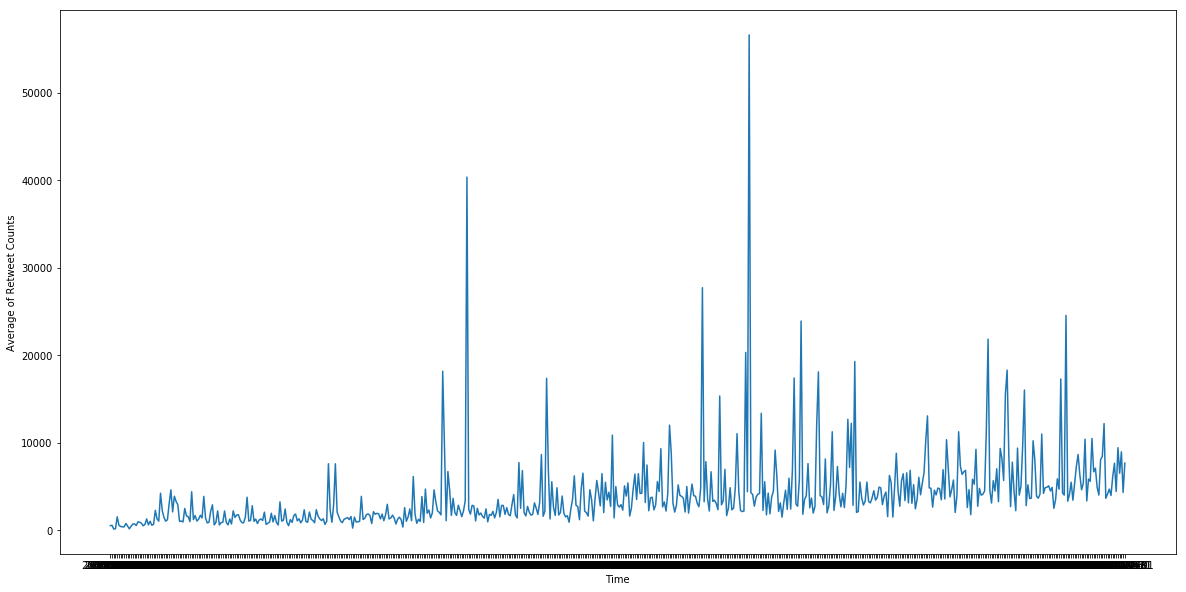

In [326]:
plt.figure(figsize=(20,10))
plt.plot(df.day,df.rt_mean)
plt.xlabel("Time")
plt.ylabel("Average of Retweet Counts")

Text(0,0.5,'Average of Favorite Counts')

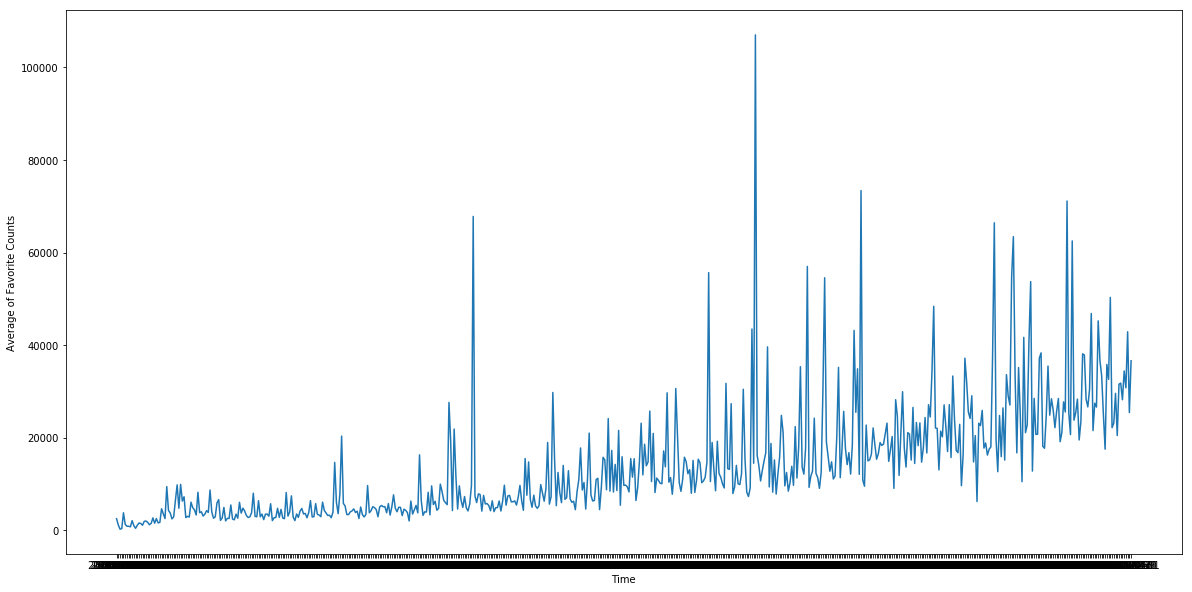

In [327]:
plt.figure(figsize=(20,10))
plt.plot(df.day,df.fav_mean)
plt.xlabel("Time")
plt.ylabel("Average of Favorite Counts")

Text(0,0.5,'Average of WeRateDogs Follower Counts')

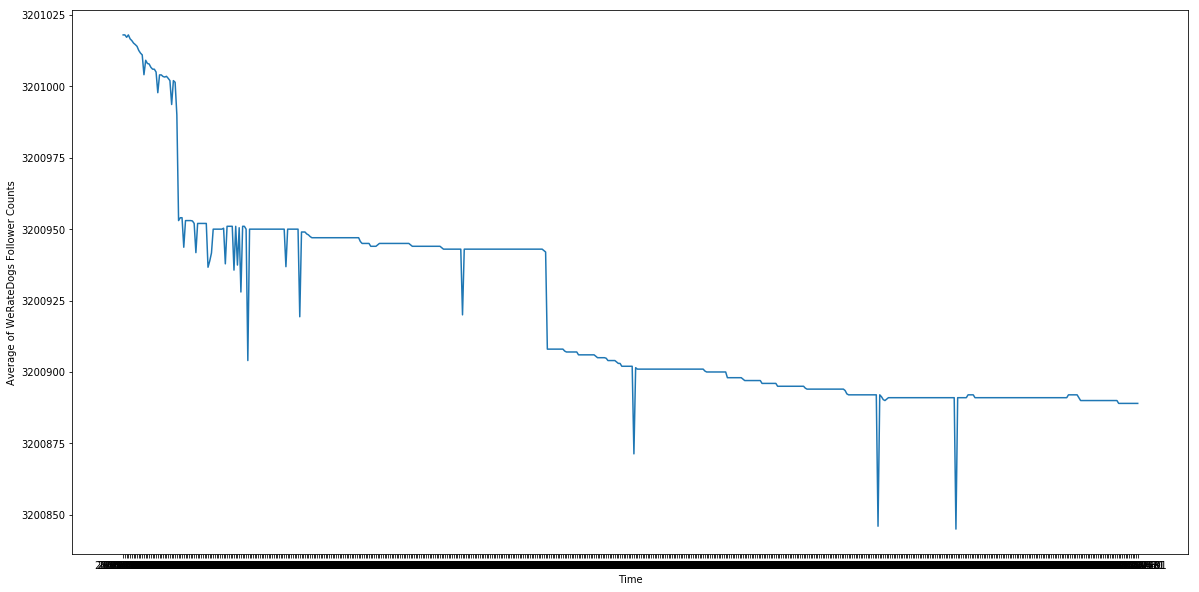

In [328]:
plt.figure(figsize=(20,10))
plt.plot(df.day,df.fol_mean)
plt.xlabel("Time")
plt.ylabel("Average of WeRateDogs Follower Counts")

When the all plots are examined in parallel, it is clear that the increasing trend of daily average of retweet and favorite counts do not coincide with the decreasing trend of WeRateDogs follower counts.